In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Dataset

In [2]:
# fetch dataset as copied from docs
# !pip install ucimlrepo            # commenting out this line as I am using local environment with uv

from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

# metadata
print(bike_sharing.metadata)

# variable information
print(bike_sharing.variables)

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'ID': 422, 'type': 'NATIVE', 'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'venue': 'Progress

In [3]:
df = pd.DataFrame(data=X)
df['target'] = y
df.head(5)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [4]:
df.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
target          int64
dtype: object

In [5]:
df = df.drop(columns='dteday')
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [6]:
X, y = df[df.columns[:-1]].to_numpy(), df[df.columns[-1]].to_numpy()

# Split Dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Decission Tree Regressor Implementation

In [8]:
class DecisionTreeRegressor:
    class _Node:
        def __init__(self, prediction=None, feature_index=None, threshold=None, left=None, right=None):
            self.prediction = prediction      # value for leaf node
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right

    def __init__(self, max_depth:int, min_samples_per_node:int, min_samples_per_leaf:int, criterion:str='MSE'):
        assert criterion=='MSE', f'criterion {criterion} not available. "MSE" expected'
        self._max_depth = max_depth
        self._min_samples_per_node = min_samples_per_node
        self._min_samples_per_leaf = min_samples_per_leaf
        self._criterion = criterion
        self._root:DecisionTreeRegressor._Node|None = None
    

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self._root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # stoppingg
        if (depth >= self._max_depth or 
            n_samples < self._min_samples_per_node or 
            n_samples <= self._min_samples_per_leaf):
            return self._Node(prediction=np.mean(y))

        # search best split
        best_feature, best_threshold, best_mse = None, None, float("inf")
        best_left, best_right = None, None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = ~left_idx
                if (sum(left_idx) < self._min_samples_per_leaf or 
                    sum(right_idx) < self._min_samples_per_leaf):
                    continue

                left_y, right_y = y[left_idx], y[right_idx]
                mse_left = np.var(left_y) * len(left_y)
                mse_right = np.var(right_y) * len(right_y)
                mse = mse_left + mse_right

                if mse < best_mse:
                    best_feature, best_threshold, best_mse = feature, t, mse
                    best_left, best_right = (X[left_idx], y[left_idx]), (X[right_idx], y[right_idx])

        # if no split improved
        if best_feature is None:
            return self._Node(prediction=np.mean(y))

        # children
        left_child = self._build_tree(best_left[0], best_left[1], depth+1)
        right_child = self._build_tree(best_right[0], best_right[1], depth+1)
        return self._Node(
            prediction=np.mean(y),
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )

    def _predict_single(self, x, node):
        if node.left is None and node.right is None:
            return node.prediction
        if x[node.feature_index] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_single(x, self._root) for x in X])

# Finding Best Fit Model Hyper-Parameters

### function to train and evaluate a model

In [9]:
from sklearn.metrics import r2_score

def train_and_score(params, X_train, y_train, X_val, y_val):
    max_depth, min_samples_per_node, min_samples_per_leaf = params
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_per_node=min_samples_per_node,
        min_samples_per_leaf=min_samples_per_leaf
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)
    return (params, r2)

### Grid Search
- As each decision Tree is independent of the other we can parallelise the execution. <br/> 
- Python has GIL as the interpreter cant run multiple threads at the same time without data race and polution so we need to use multiprocessing

In [10]:
from itertools import product
from concurrent.futures import ProcessPoolExecutor

def grid_search(X_train, y_train, X_val, y_val):
    list_max_depth = np.arange(start=10, stop=19, step=1)
    list_min_samples_per_nodes = np.arange(start=7, stop=13, step=1)
    list_min_samples_per_leaves = np.arange(start=2, stop=8, step=1)

    param_grid = list(product(
        list_max_depth,
        list_min_samples_per_nodes,
        list_min_samples_per_leaves
    ))

    results = []
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(train_and_score, params, X_train, y_train, X_val, y_val)
            for params in param_grid
        ]
        for f in futures:
            results.append(f.result())
    
    best_params, best_r2 = max(results, key=lambda x: x[1])
    return best_params, best_r2, results

In [11]:
best_params, best_r2, results = grid_search(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
print(f'best parameters: {best_params} and best r2 score: {best_r2}')

best parameters: (np.int64(14), np.int64(11), np.int64(3)) and best r2 score: 0.8852802700222291


# Evaluation on test set

In [12]:
best_max_depth, best_min_samples_per_node, best_min_samples_per_leaf = (best_params)

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

impl_best_model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_per_leaf=best_min_samples_per_leaf, min_samples_per_node=best_min_samples_per_node)

impl_best_model.fit(X_trainval, y_trainval)
y_test_pred = impl_best_model.predict(X_test)

impl_test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print(f'test set r2 score: {impl_test_r2}')

test set r2 score: 0.9437597049863679


# MSE on test dataset

In [13]:
from sklearn.metrics import mean_squared_error

impl_test_mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print(f'mean squared error on test set: {impl_test_mse}')

mean squared error on test set: 1895.497111812033


# Scatter plot of predicted values vs true values for test data

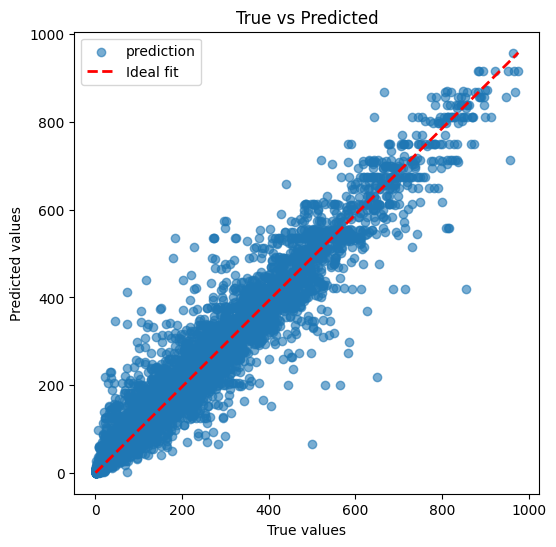

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='prediction')
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], color="red", linestyle="--", linewidth=2, label="Ideal fit")

plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted")
plt.legend()
plt.show()

# test on sklearn model

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": np.arange(10, 19, 1),
    "min_samples_split": np.arange(7, 13, 1),
    "min_samples_leaf": np.arange(2, 8, 1)
}

search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1
)


search.fit(X_trainval, y_trainval)

Traceback (most recent call last):
  File "/home/kingshuk/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_9352_37154e362480499c88781c1997bf5c17_db896b8bffc1449bb18e43a9f8a8cc3c for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/kingshuk/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-9352-g5gcbz27 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/kingshuk/.local/share/uv/python/cpython-3.13.7-linux-

,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'max_depth': array([10, 11..., 16, 17, 18]), 'min_samples_leaf': array([2, 3, 4, 5, 6, 7]), 'min_samples_split': array([ 7, 8..., 10, 11, 12])}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [16]:
print("Best Hyperparameters:", search.best_params_)
print("Best CV R²:", search.best_score_)

sk_best_tree = search.best_estimator_
sk_y_pred = sk_best_tree.predict(X_test)

print("Test R2 with Best Params:", r2_score(y_test, sk_y_pred))
print("Test RMSE with Best Params:", mean_squared_error(y_test, sk_y_pred))

Best Hyperparameters: {'max_depth': np.int64(16), 'min_samples_leaf': np.int64(3), 'min_samples_split': np.int64(12)}
Best CV R²: 0.9117258716908475
Test R2 with Best Params: 0.945767792439266
Test RMSE with Best Params: 1827.8174531916088


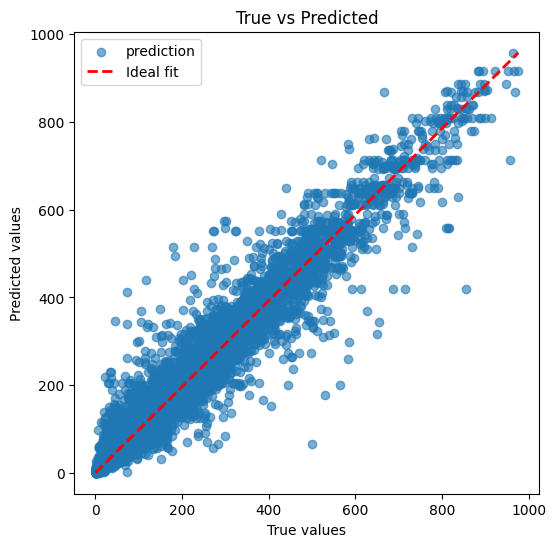

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, sk_y_pred, alpha=0.6, label='prediction')
plt.plot([y_test.min(), y_test.max()], [sk_y_pred.min(), sk_y_pred.max()], color="red", linestyle="--", linewidth=2, label="Ideal fit")

plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted")
plt.legend()
plt.show()

# sklearn tree visualization

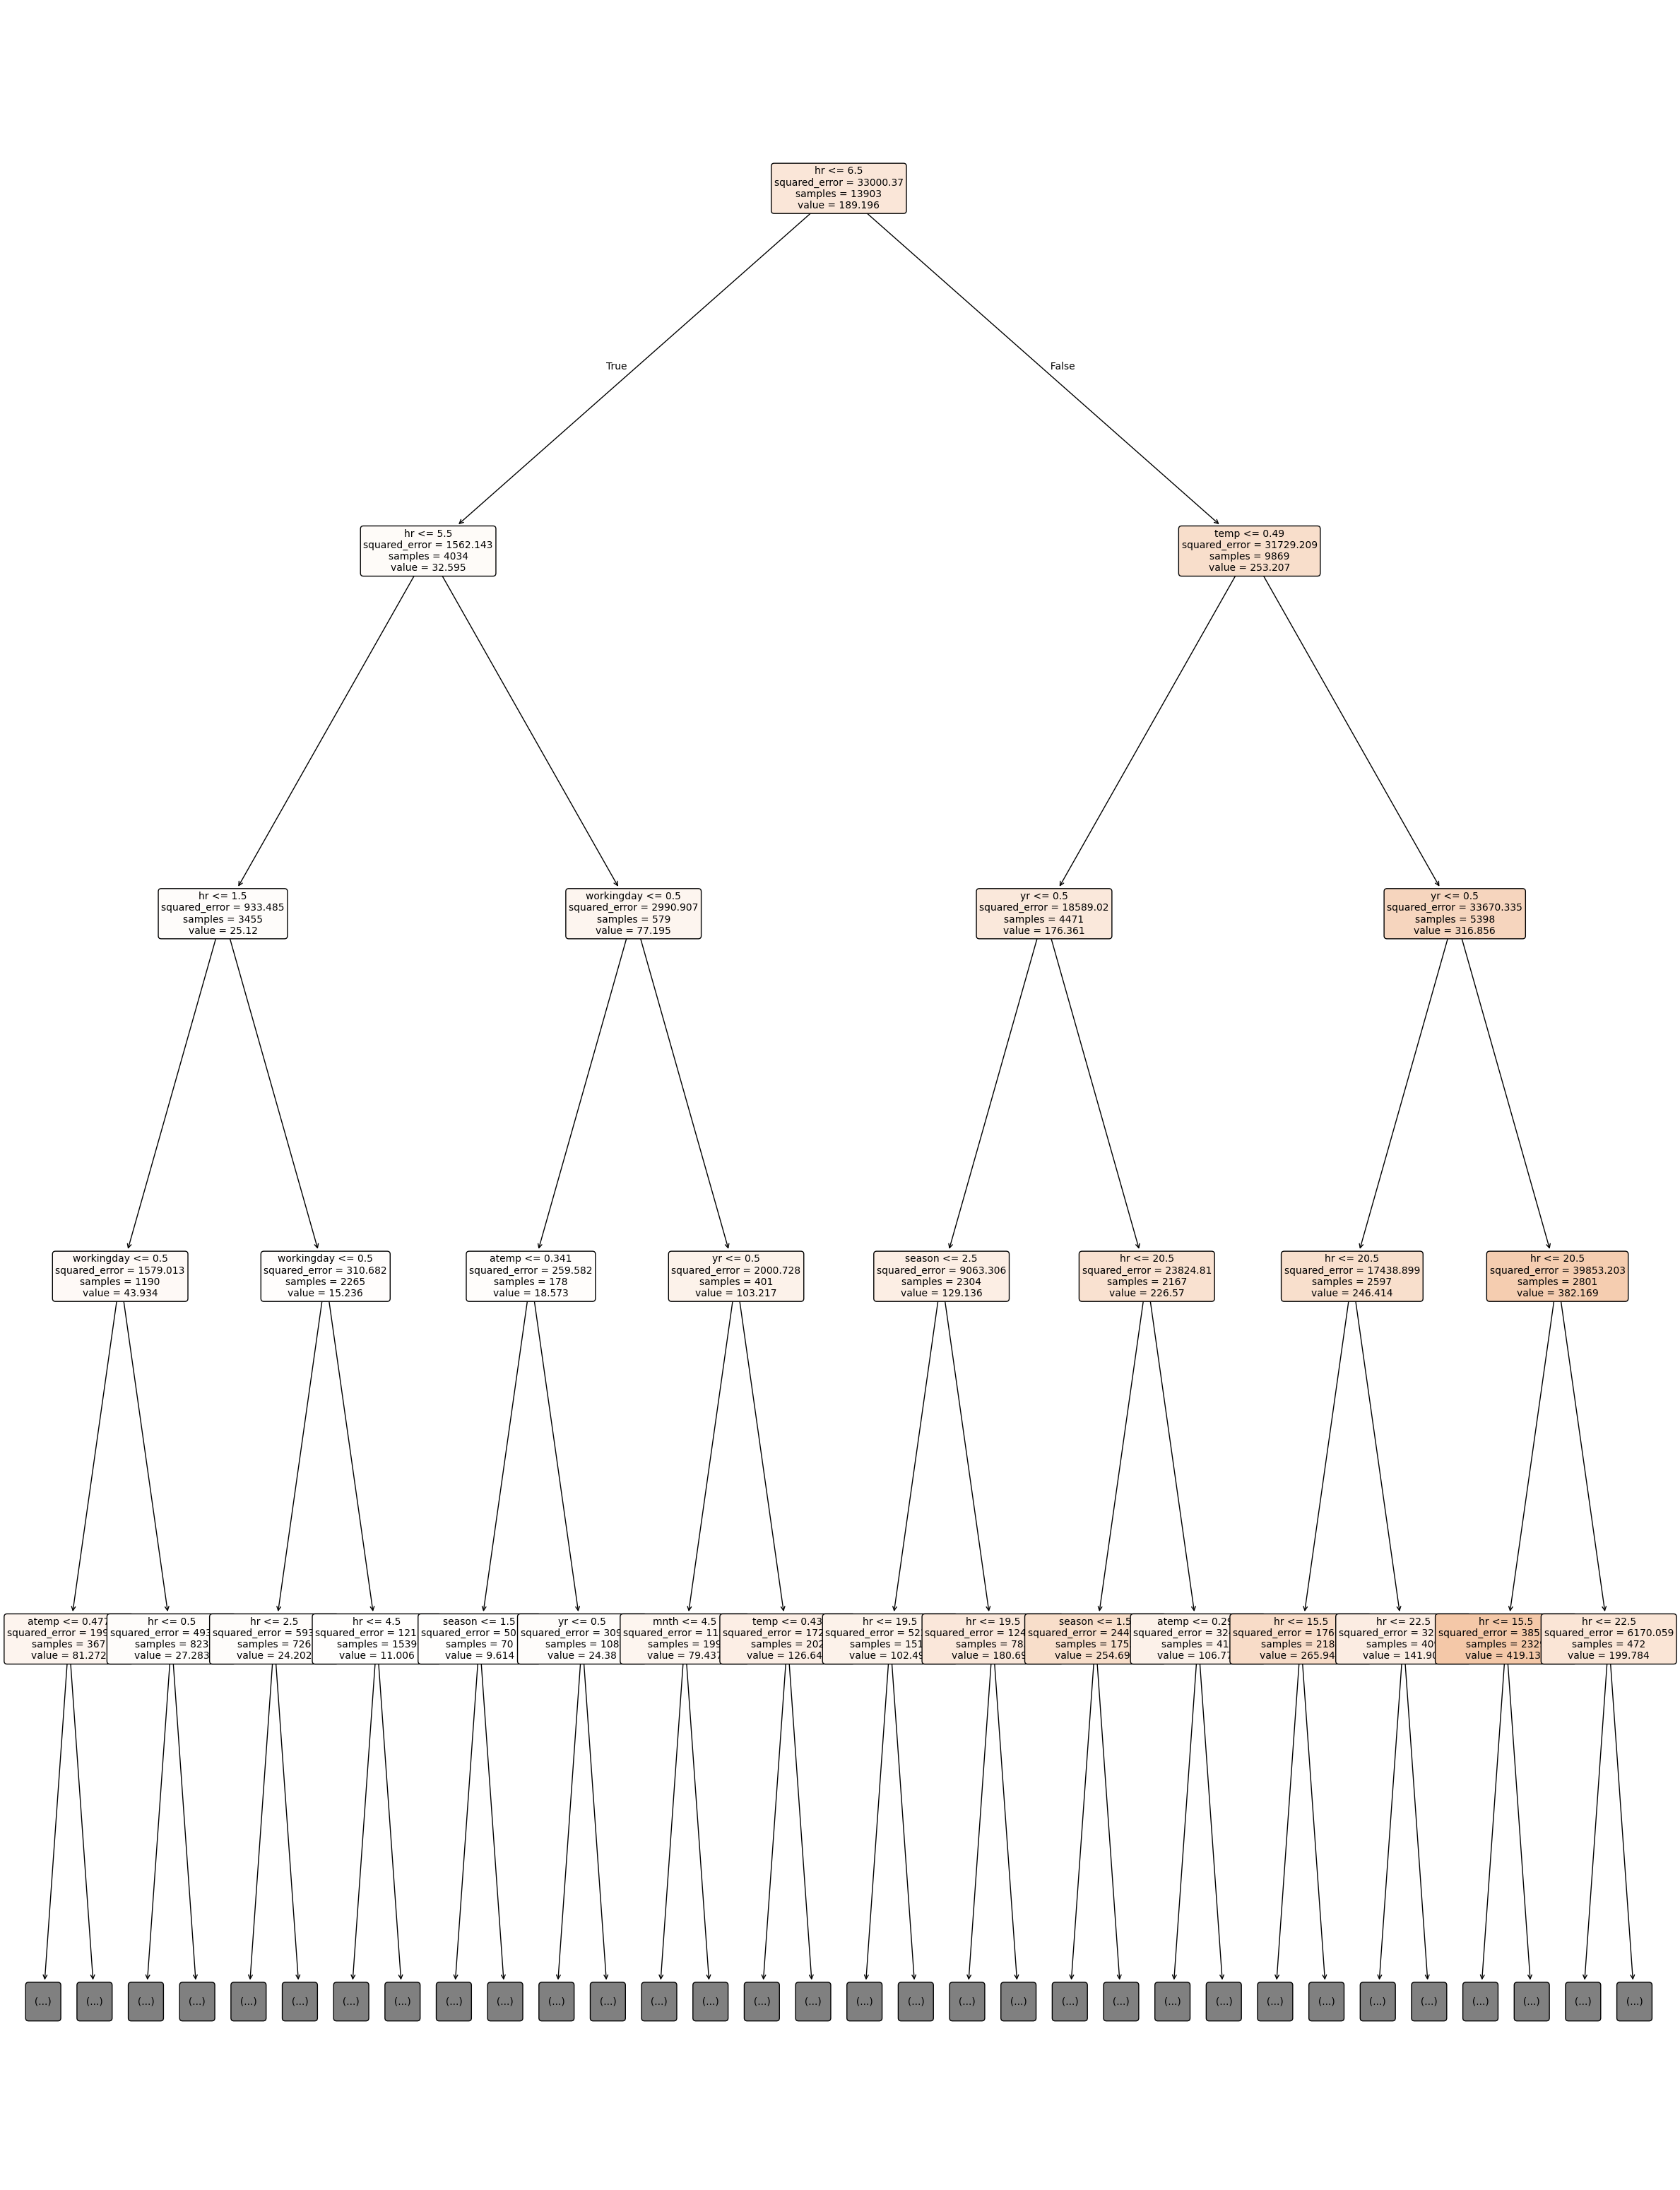

In [18]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,40))

plot_tree(sk_best_tree, feature_names=df.columns[:-1], filled=True, rounded=True,fontsize=10, max_depth=4)
plt.show()

# comparision

In [19]:
print('Hyper Parameters')
print('custom implementation')
print(f'max depth: {best_max_depth}')
print(f'min samples per node: {best_min_samples_per_node}')
print(f'min samples per leaf: {best_min_samples_per_leaf}')

print('sklearn implementation')
print(f'max depth: {search.best_params_["max_depth"]}')
print(f'min samples per node: {search.best_params_["min_samples_split"]}')
print(f'min samples per leaf: {search.best_params_["min_samples_leaf"]}')

Hyper Parameters
custom implementation
max depth: 14
min samples per node: 11
min samples per leaf: 3
sklearn implementation
max depth: 16
min samples per node: 12
min samples per leaf: 3


In [20]:
print('r2 score')
print(f'sklearn implementation: {search.best_score_}')
print(f'custom implementation:  {impl_test_r2}')

r2 score
sklearn implementation: 0.9117258716908475
custom implementation:  0.9437597049863679
